## Segmentación individualizada de agrupaciones celulares

En el notebook anterior-"Segmentación de células en preparaciones microscópicas"- se ha visto como utilizando los métodos más habituales de segmentación de imágenes -método de *watershed* y método *threshold*-, se dan casos de infra-segmentación y sobre-segmentación. Para resolver este problema, el proyecto presentado pretende individualizar la segmentación. Es decir, primeramente se realizará una segmentación conservadora -eliminando sólo el ruido de fondo- obteniendo unos objetos segmentados que podrán ser clasificados en : una única célula presente o dos o más células. Posteriormente, utilizarán las CNN para clasificar dichos objetos segmentados en los dos grupos anteriormente considerados. Finalmente, para aquellos objetos segmentados que hayan sido clasificados como agraciones celulares de dos o más células, se llevará a cabo una ulterior segmentación.

Por tanto, el fundamento de este notebook es como realizar la segmentación individualizada en agrupaciones celulares. Para ello se propondrán diferentes metodologías y se evaluará su efectividad con diferenes agrupaciones ceúlares reales.


# Métodos de segmentación:

    - Método de *watershed*
    - Métodos por *clustering*: *kmeans*, *aglomerative clustering*, mezcla gaussiana, mezcla gaussiana por método de Bayes.

El método de *watershed* ya fue presentado en el notebook: "Segmentación de células en preparaciones microscópicas". 

Los métodos de *clustering* o de agrupamiento, se basan en agrupar un conjunto de objetos en diferentes clases según su similaridad. Para el caso que nos ocupa la similaridad es la cercanía que existe entre dos pixels. Existen varios modelos como son: modelos de conectividad ( agrupamiento jerárquico que construye modelos basados en la distancia de las conexiones, como en el caso del cluster aglomerativo), modelo de centroide (k-means o de mezcla gaussiana), modelo de densidad (DBSCAN). 

La ventaja de utilizar los métodos de clustering es que previmente definimos cuantos cluster queremos crear y dado que en el caso que nos ocupa se analizaran imágenes con al menos dos células el número de cluster a crear es 2.


### Análisis de los modelos de segmentación:

Se analizarán imágenes de células con resolución 192x192 obtenidas de las imágenes originales (1024x1024), mediante previa segmentación por método de threshold de Li.

Librerias a utilizar:

In [1]:
import skimage
from skimage import data
from skimage.filters import threshold_li
from skimage import io
from skimage.measure import label, regionprops
import numpy as np
import matplotlib.pyplot as plt
import mahotas as mh
import os
import sys
import time
#Cargar el directorio de trabajo
os.chdir("./Data/CellClusters")

Imágen de una doble célula:

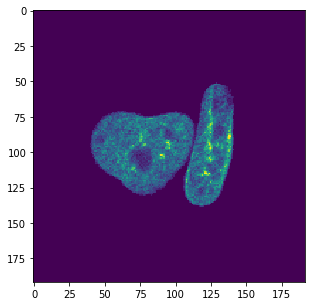

In [2]:
image = "V.tif" 
patch_image = io.imread(image)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(patch_image)

#### Segmentación por *watershed* fijado el valor sigma en 12:

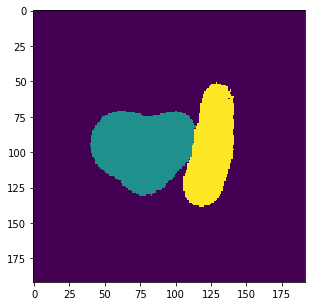

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))
sigma = 12
def watershed (image, sigma):
    t0 = time.time()
    T_min = threshold_li(image)
    bin_image = image > T_min
    dnaf = mh.gaussian_filter(image.astype(float), sigma)
    maxima = mh.regmax(mh.stretch(dnaf))
    maxima,_ = mh.label(maxima)
    dist = mh.distance(bin_image)
    dist = 255 - mh.stretch(dist)
    watershed = mh.cwatershed(dist, maxima)
    watershed *= bin_image
    t1 = time.time()
    return (t1-t0, watershed)

plt.imshow(watershed(patch_image, sigma)[1])


#### Segmentación por método de clustering Kmeans:

El método de Kmeans es un agrupamiento basado en el centroide, los grupos estan representados por un vector central k. Tiene como objetivo la partición de un conjunto de n muestras en k grupos en el que cada observación pertenece al grupo cuyo valor medio es más cercano.

El algoritmo k-means++ mejora el método k-means dado que lleva a cabo un procedimiento para inicializar los centros de los clusters antes de proceder con las iteraciones de optimización.

Como inconveniente del método de k-means es que no funciona bien con clusters de diferente tamaño forma y densidad.

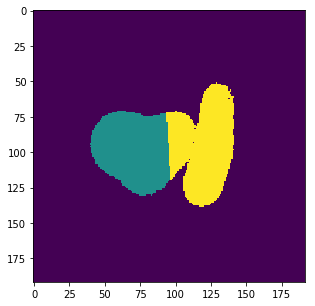

In [4]:
from sklearn.cluster import KMeans

def kmean (image):
    t0 = time.time()
    T_min = threshold_li(image)
    bin_image = image > T_min
    lcc = label(bin_image)
    for region in regionprops(lcc, image):
        if region.area >= 500:
            cluster = region
            kmeans = KMeans(n_clusters=2,
                        init="k-means++",
                        n_init=100,
                        max_iter=1000,
                        algorithm="auto").fit(region.coords)    
            break

    
    cast = np.zeros((192,192))
    c = kmeans.fit_predict(region.coords)
    for i in range(region.coords.shape[0]):
        cast[region.coords[i,0],region.coords[i,1]]=c[i]+1
    t1 = time.time()
    return (t1-t0,cast)
     

fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(kmean(patch_image)[1])

#### Segmentación por método de clustering aglomerativo:

El método por clustering aglomerativo se clasifica dentro de los agrupamientos jerárquicos. Se basa en la idea de que los objetos más cercanos están más realacionados que los que están más alejados. Por tanto, la formación de clusters depende de la distancia entre datos.

Como ventaja frente al método de k-means es que es capaz de dividir clusters de diferente tamaño y forma. Pero como inconveniente es que los límites que forman no son tan lisos como los del método de k-means.

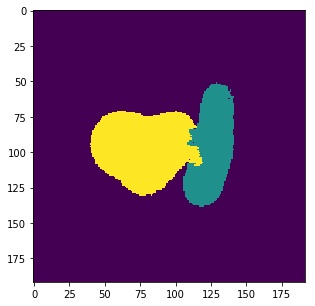

In [5]:
from sklearn.cluster import AgglomerativeClustering


def AC (image):
    t0 = time.time()
    T_min = threshold_li(image)
    bin_image = image > T_min
    lcc = label(bin_image)
    for region in regionprops(lcc, image):
        if region.area >= 500:
            AC = AgglomerativeClustering(n_clusters = 2,
                             linkage = "average").fit(region.coords)  
            break
    cast = np.zeros((192,192))
    c = AC.fit_predict(region.coords)
    for i in range(region.coords.shape[0]):
        cast[region.coords[i,0],region.coords[i,1]]=c[i]+1
    t1 = time.time()
    return (t1-t0, cast)


fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(AC(patch_image)[1])

#### Segmentación por método de clustering mixto gaussiano:

El método por clustering mixto gaussiano es un método generaĺ del modelo k-means que incorpora información sobre la estructura de los datos. La utilización de método mixto gaussiano es debido a que los núcleos celulares suelen presentarse de forma esferica o ovalada.

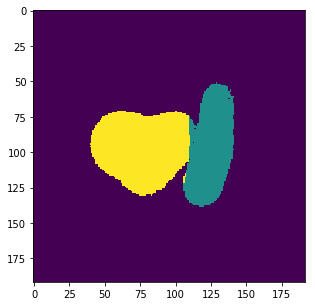

In [6]:
from sklearn import mixture

def Gauss (image):
    t0 = time.time()
    T_min = threshold_li(image)
    bin_image = image > T_min
    lcc = label(bin_image)
    for region in regionprops(lcc, image):
        if region.area >= 500:
            cluster = region
            Gauss = mixture.GaussianMixture(n_components = 2,
                                covariance_type = 'full').fit(region.coords)
  
            break
    
    cast = np.zeros((192,192))
    c = Gauss.predict(region.coords)
    for i in range(region.coords.shape[0]):
        cast[region.coords[i,0],region.coords[i,1]]=c[i]+1
    t1 = time.time()
    return (t1-t0,cast)


fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(Gauss(patch_image)[1])

### Comparación de los diferentes métodos en diferentes clases de agrupaciones celulares

Con el fin de llevar a cabo un análisis más exaustivo sobre los diferentes métodos de segmentación, se procederá a analizar diferentes casos de agrupaciones celulares con los diferentes métodos de segmentación, así como el tiempo de procesado para cada análisis. En total se analizarán 7 imágenes de agrupaciones celulares con diferentes situaciones. Las imágenes utilizadas corresponden por orden a: dos núcleos con formas circulares ligeramente pegadas entre sí, dos núcleos ovaladas ligeramente pegadas entre sí, dos núcleos ovaladas solapadas parcialmente por el cuerpo del nucleo, dos núcleos ovaladas ligeramente solapadas por los extremos, dos núcleos pegadas con formas no esféricas, tres núcleos pegados entre sí, cuatro nucleos pegados entre sí.

Se utilizarán los siguientes métodos de segmentación: método de watershed con un valor de sigma de 6, método de watershed con un valor de sigma de 12, método de agrupación K-means++, método de agrupación aglomerativa y método de agrupación mixto gaussiano.

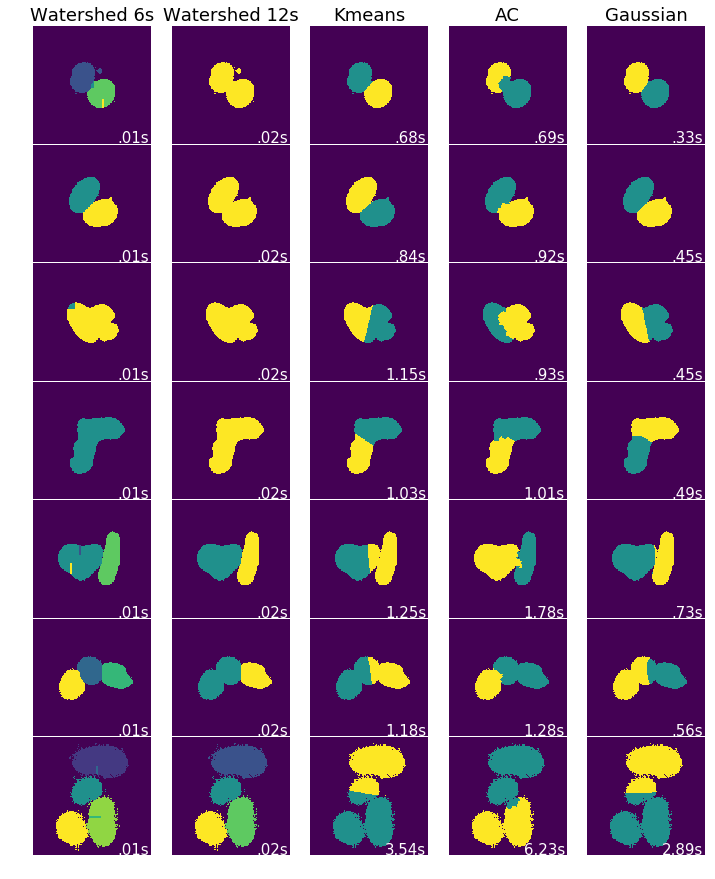

In [22]:
### Comparación de los diferentes métodos en diferentes clases de agrupaciones celulares

# ============
# Convertir las imágenes de agrupaciones celulares en matrices
# ============

images = [s for s in os.listdir(".") if ".tif" in s]
images_M = [io.imread(i) for i in images]


# ============
# Crear la tabla y los gráficos
# ============
font = {"color": "white"}

plt.figure(figsize=(10,12))
plt.subplots_adjust(left=.02, right=.98,
                    bottom=.001, top=.96,
                    wspace=0.01,
                    hspace=.01)

plot_num = 1
clustering_algorithms = 5
i=0
for n, image in enumerate(images_M):
    plt.subplot(len(images_M), clustering_algorithms, plot_num)
    plt.axis("off")
    t, matrix = watershed(image, 6)
    plt.text(.99, .01, ('%.2fs' % (t)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right', fontdict=font)
    if i==0:
        plt.title("Watershed 6s", size = 18)
    plt.imshow(matrix)
    plot_num += 1
    
    plt.subplot(len(images_M), clustering_algorithms, plot_num)
    plt.axis("off")
    t, matrix = watershed(image, 12)
    plt.text(.99, .01, ('%.2fs' % (t)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right', fontdict=font)
    if i==0:
        plt.title("Watershed 12s", size = 18)
    plt.imshow(matrix)
    plot_num += 1
    
    plt.subplot(len(images_M), clustering_algorithms, plot_num)
    plt.axis("off")
    t, matrix = kmean (image)
    plt.text(.99, .01, ('%.2fs' % (t)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right', fontdict=font)
    if i==0:
        plt.title("Kmeans", size = 18)
    plt.imshow(matrix)
    plot_num += 1
    
    
    plt.subplot(len(images_M), clustering_algorithms, plot_num)
    plt.axis("off")
    t, matrix = AC(image)
    plt.text(.99, .01, ('%.2fs' % (t)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right', fontdict=font)
    if i==0:
        plt.title("AC", size = 18)
    plt.imshow(matrix)
    plot_num += 1
    
    plt.subplot(len(images_M), clustering_algorithms, plot_num)
    plt.axis("off")
    t, matrix = Gauss(image)
    plt.text(.99, .01, ('%.2fs' % (t)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right', fontdict=font)
    if i==0:
        plt.title("Gaussian", size = 18)
    plt.imshow(matrix)
    plot_num += 1
    i+=1

plt.show()

Se puede observar como los métodos de segmentación por *watershed* son mas rápidos que los métodos por clutering. Por otra parte, mientras que con el método de segmentación por watershed se pueden obtener más de dos segmentaciones, con los métodos de clustering al fijarse el número de cluster en dos: siempre obtendremos 2 clases.

Si análizamos cada método indiviualmente. El método de watershed con valor de sigma 6 es el único que segmenta bien la imágen 6 en tres células, pero por otra parte en otras imagenes ocurre una sobre-segmentación. Con método de watershed con valor de sigma 12 no ocurre la sobre-segmentación, aunque no es capáz de separar los nucleos 1,2,3 y 4. El método de clustering con k-means el el que da un resultado más pobre ya que se dan casos con una segmentación deficiente en los núcleos: 3,4, 6 y 7. El método de segmentación por clustering aglomerativo es capáz de separar los núcleos celulares, aunque presenta un problema en como situa los límites de la semgentación. El método de clustering mixto gaussiano da muy buenos resultados en los casos que existen 2 núcleos celulares pero un pobre resultado con los casos que existen más de dos núcleos.

Aunque individualmente los métodos que mejor resultado dan son los métodos de clustering aglomerativos y de clustering mixto gaussiano, la combinación entre los métodos de segmentación watershed con valor de sigma 12 -con muy buenos resultados en nucleos ligeramente pegados entre sí- y el método de clustering mixto gaussiano -segmentando muy bien los casos en que existen solapamiento nuclear- son los que mejor resultado dan en conjunto.